# End-to-End Optimal Character Recognition (OCR)

In [1]:
#library Import

import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


## Load Data 

In [2]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## Build Recognition Model

In [3]:
#class 확인
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
#라이브러리 불러오기
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)


/aiffel/aiffel/ocr/data/MJ/MJ_train


### Input Image

데이터셋의 실제 이미지의 형태와 모양을 확인 (라벨 포함).

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


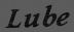

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


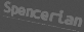

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


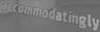

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


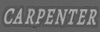

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

lmdb 데이터를 사용하요 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현 합니다.
max_readers: 동시에 최대 읽을 수 있는 데이터 수
readonly: 읽기 전용
lock: 잠금 설정
readhead: OS 파일 시스템 미리 읽기 메커니즘
meminit: 버퍼를 디스크에 쓰기 전에 0으로 초기화 할지 결정

In [8]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("go")

go


### Encode and Decode
1. Label Convert
2. Calculating CTC loss
3. CRNN model

In [10]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [11]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [12]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [13]:
#Build CRNN Model

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    sequence = layers.Reshape(target_shape=(24, 512))(feature)
    sequence = layers.Dense(64, activation='relu')(sequence)
    sequence = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequence)
    sequence = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequence)
    
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequence)
    

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

# Model Training

In [14]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=15,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/15
565/565 [==============================] - 579s 977ms/step - loss: 25.5190 - val_loss: 23.4597

Epoch 00001: val_loss improved from inf to 23.45975, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/15
565/565 [==============================] - 83s 147ms/step - loss: 15.2408 - val_loss: 9.9715

Epoch 00002: val_loss improved from 23.45975 to 9.97150, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/15
565/565 [==============================] - 83s 147ms/step - loss: 7.3319 - val_loss: 6.9336

Epoch 00003: val_loss improved from 9.97150 to 6.93357, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/15
565/565 [==============================] - 83s 146ms/step - loss: 5.2596 - val_loss: 5.6414

Epoch 00004: val_loss improved from 6.93357 to 5.64140, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/15
565/565 [==============================] - 83s 147ms/step - loss: 4.1644 - val_loss: 4.8190

Epoch 00005: val_loss impr

In [18]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


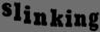

Result: 	 ALEPPO99999999999999999


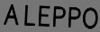

Result: 	 FWENDE999999999999999999


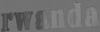

Result: 	 NATHANS99999999999999999


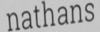

Result: 	 HALLE999999999999999999


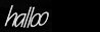

Result: 	 HUERLS999999999999999999


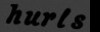

Result: 	 DOWNSIZE9999999999999999


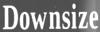

Result: 	 ROBOTIC99999999999999999


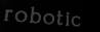

Result: 	 STOPPY99999999999999999


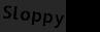

Result: 	 HERMITE99999999999999999


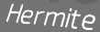

In [38]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

Result: 	 SLINKING


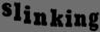

Result: 	 ALEPPO


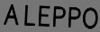

Result: 	 FWENDE


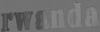

Result: 	 NATHANS


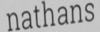

Result: 	 HALLE


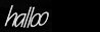

Result: 	 HUERLS


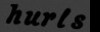

Result: 	 DOWNSIZE


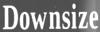

Result: 	 ROBOTIC


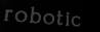

Result: 	 STOPPY


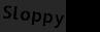

Result: 	 HERMITE


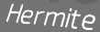

In [97]:
# TARGET_CHARACTERS는 전역적으로 정의되어 있다고 가정
# 예: TARGET_CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
DECODER_CHARS = "-" + TARGET_CHARACTERS # LabelConverter와 일치하는 디코딩용 문자셋

def decode_predict_ctc_refined(out, chars=DECODER_CHARS): # chars의 기본값을 일관되게 설정
    results = []
    # K.get_value 및 인덱싱은 배치 크기 1, top_paths=1을 가정
    decoded_indices_tensor = K.ctc_decode(
        out, input_length=np.ones(out.shape[0]) * out.shape[1],
        greedy=False, beam_width=5, top_paths=1 # 현재 사용 중인 beam search 설정 유지
    )[0][0] # 첫 번째 경로, 첫 번째 배치 아이템의 SparseTensor 또는 이와 유사한 텐서

    indexes = K.get_value(decoded_indices_tensor)[0] # 실제 인덱스 시퀀스 추출 (환경에 따라 이 부분이 다를 수 있음)
                                                    # 만약 decoded_indices_tensor가 SparseTensor라면, 
                                                    # K.get_value(decoded_indices_tensor.values) 와 같이 접근해야 할 수 있습니다.
                                                    # 혹은 이미 dense tensor일 수도 있습니다. user의 기존 코드는 [0]을 한번 더 썼습니다.

    text = ""
    for index_val in indexes:
        if index_val == -1:  # K.ctc_decode는 시퀀스 끝을 -1로 패딩할 수 있음
            break
        text += chars[int(index_val)] # 정수형 인덱스로 접근

    # 1. CTC 공백 문자('-') 제거 (이미 LabelConverter의 '-'와 DECODER_CHARS의 '-'가 일치하므로, 여기서 제거)
    text = text.replace('-', '')

    # 2. "999..." 같은 숫자 연속 접미사 제거 (더 정교한 방법이 필요할 수 있음)
    #    여기서는 문자열 끝에서 연속된 '9'를 제거하는 간단한 방법을 사용합니다.
    #    MJ Synth 데이터의 정답은 대부분 알파벳이므로, 숫자 접미사는 노이즈일 가능성이 높습니다.
    import re
    # 정규표현식을 사용하여 문자열 끝의 '9'가 3개 이상 반복되는 패턴을 찾아 제거
    cleaned_text = re.sub(r'9{3,}$', '', text) 
    
    results.append(cleaned_text.strip()) # 최종적으로 양쪽 공백 제거
    return results

# check_inference 함수에서 호출 시:
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:] # dataset[i][0] 대신 inputs 사용
        output_pred = model.predict(img) # 변수명 변경 (output은 파이썬 내장 함수)
        
        # 수정된 decode_predict_ctc_refined 함수 사용
        # chars 인자를 명시적으로 전달하지 않아도 DECODER_CHARS 기본값 사용
        result = decode_predict_ctc_refined(output_pred)[0] 
        
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [98]:
# End-to-End OCR 
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [108]:
def detect_text(img_path):
    # TODO
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)    
    img_pil = Image.open(img_path)
    img_draw = ImageDraw.Draw(img_pil)
    ocr_result = detector.detect([img_path])
    ocr_result = np.squeeze(np.array(ocr_result))
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

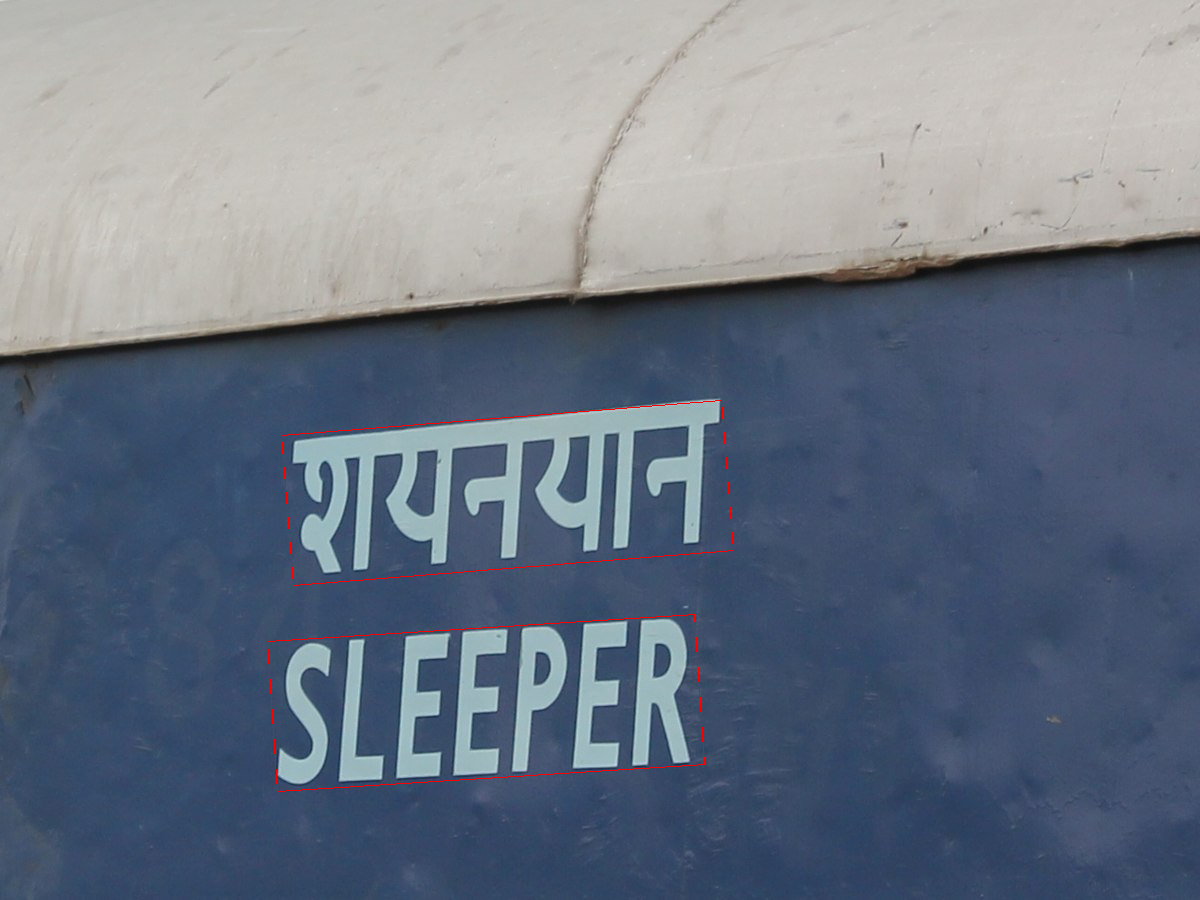

In [109]:
from PIL import ImageDraw

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [112]:
import re # 정규표현식을 사용하기 위해 임포트합니다 (스크립트 상단에 한 번만 해주셔도 됩니다).
from PIL import Image # Image.Resampling 을 사용하기 위해 임포트합니다.

# 이전에 정의된 전역 변수들을 가정합니다:
# TARGET_CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
# model_pred = # 학습된 CRNN 모델
# decode_predict_ctc = # 사용자 정의 디코딩 함수

# LabelConverter와 일치하는 디코딩용 문자셋 정의
DECODER_CHARS = "-" + TARGET_CHARACTERS

def recognize_img(pil_img, input_img_size=(100,32)):
    # 1. 이미지 전처리 (Pillow 리샘플링 필터 수정 포함)
    try:
        # Pillow 9.1.0 버전 이상
        resampling_filter = Image.Resampling.LANCZOS
    except AttributeError:
        # 구버전 Pillow
        resampling_filter = Image.ANTIALIAS

    # input_img_size = (너비, 높이)로 가정합니다. 예: (100, 32)
    # 모델이 (높이, 너비, 채널) 입력을 받는다고 가정하고,
    # resize 후 np.array()는 (높이, 너비, 채널)이므로, (32, 100, 채널)이 됩니다.
    # transpose(1,0,2)를 하면 (100, 32, 채널)이 되어 모델 입력 (높이 100, 너비 32)에 맞춥니다.
    resized_pil = pil_img.resize((input_img_size[0], input_img_size[1]), resampling_filter)
    img_np = np.array(resized_pil)

    # 채널 수 맞추기 (그레이스케일 -> RGB, RGBA -> RGB)
    if len(img_np.shape) == 2:
        img_np = np.stack([img_np] * 3, axis=-1)
    elif img_np.shape[2] == 4:
        img_np = img_np[:, :, :3]
    
    processed_img_for_model = img_np.transpose(1, 0, 2)
    input_tensor = np.expand_dims(processed_img_for_model, axis=0)

    # 2. 모델 예측
    output_pred = model_pred.predict(input_tensor)

    # 3. 초기 디코딩 (사용자의 decode_predict_ctc 함수 사용)
    #    이때 chars 인자는 DECODER_CHARS를 사용해야 LabelConverter와 일치합니다.
    initial_result_from_decode = decode_predict_ctc(output_pred, chars=DECODER_CHARS)[0]
    
    # 4. 후처리 단계
    # 4.1. CTC 공백 문자 '-' 제거 (decode_predict_ctc에서 이미 처리했다면 중복될 수 있으나, 확실히 하기 위함)
    text_no_blanks = initial_result_from_decode.replace('-', '')

    # 4.2. "999..." 와 같은 연속된 숫자 '9' 접미사 제거
    #      정규표현식을 사용하여 문자열 끝에서 '9'가 3번 이상 반복되는 부분을 찾아 제거합니다.
    cleaned_text_suffix_removed = re.sub(r'9{3,}$', '', text_no_blanks)
    
    # 4.3. 최종적으로 양쪽 공백이 있다면 제거
    final_result = cleaned_text_suffix_removed.strip()

    print("Result: \t", final_result) # 최종 정제된 결과 출력
    
    # 입력으로 사용된 원본 단어 이미지(pil_img)를 표시하여 맥락 파악 용이
    display(pil_img)

Result: 	 SFFUFT


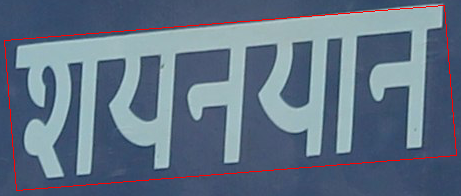

Result: 	 SLEEPER


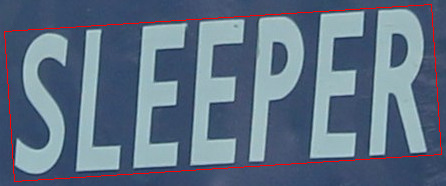

In [113]:
for _img in cropped_img:
    recognize_img(_img)

In [114]:
SAMPLE_IMG_PATH = HOME_DIR + '/data1/sample2.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


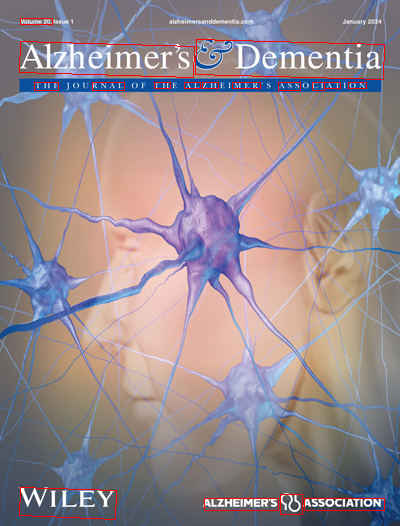

In [115]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 CEIEATS


Result: 	 EPEMENTIAL


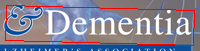

Result: 	 AZLEIMERS


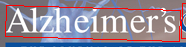

Result: 	 SEIEN


Result: 	 ESNIES


Result: 	 SAS


Result: 	 SIAS


Result: 	 SCIALAES


Result: 	 RIATIN


Result: 	 SESIN


Result: 	 SITES


Result: 	 ETES


Result: 	 FAES


Result: 	 WYILEY


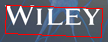

Result: 	 CIRATSIS


Result: 	 HLTHEIMERST


Result: 	 FHESSOCIATIONS


In [116]:
for _img in cropped_img:
    recognize_img(_img)

In [117]:
SAMPLE_IMG_PATH = HOME_DIR + '/data1/sample3.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


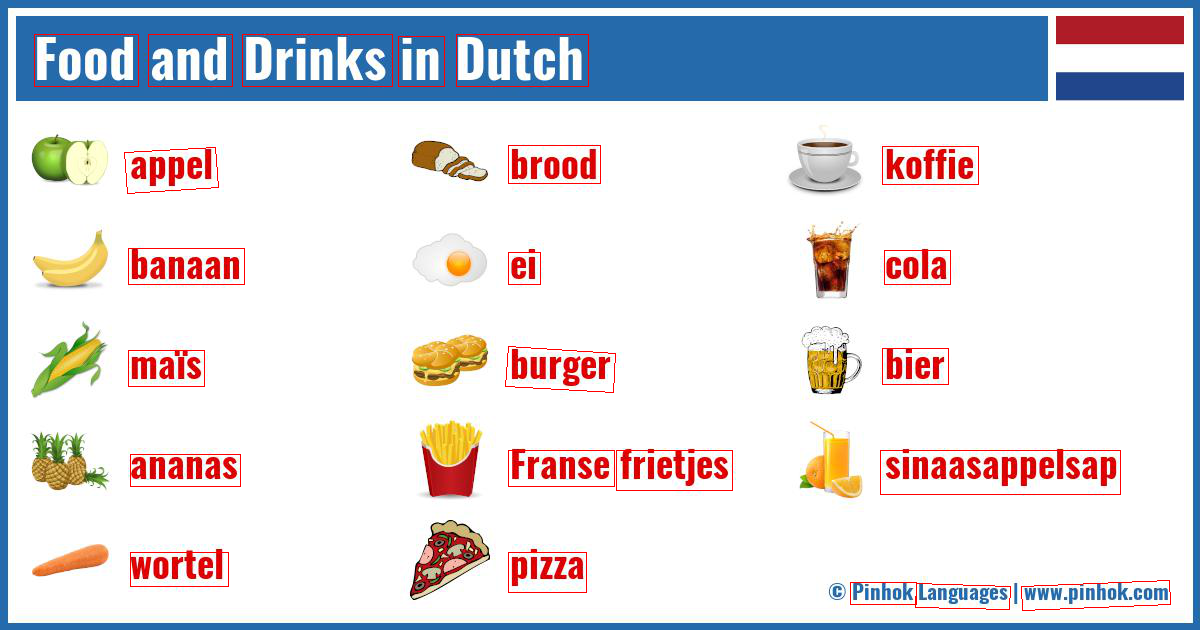

In [118]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 FODS


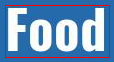

Result: 	 HARIDLS


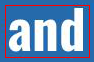

Result: 	 ORINKS


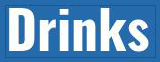

Result: 	 DUTCHIS


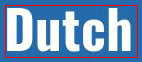

Result: 	 TUS


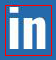

Result: 	 HRODI


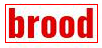

Result: 	 IKGFFIEL


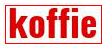

Result: 	 TAIUFPELT


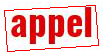

Result: 	 BTATAEL


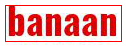

Result: 	 LATDEAL


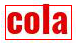

Result: 	 TUEATL


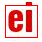

Result: 	 JFHURGERT


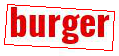

Result: 	 LIEARL


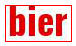

Result: 	 LEITEATSL


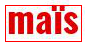

Result: 	 FRAISEL


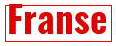

Result: 	 JFRIETIEST


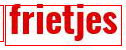

Result: 	 SFIFRISATTEISAT


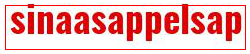

Result: 	 AITAITEST


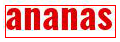

Result: 	 HORTELN


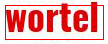

Result: 	 LFPIZEA


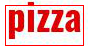

Result: 	 PINHOKL


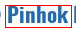

Result: 	 SLAIGUAGES


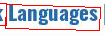

Result: 	 TYHARDIRBOKENT


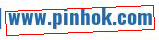

In [119]:
for _img in cropped_img:
    recognize_img(_img)

In [120]:
SAMPLE_IMG_PATH = HOME_DIR + '/data1/sample4.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


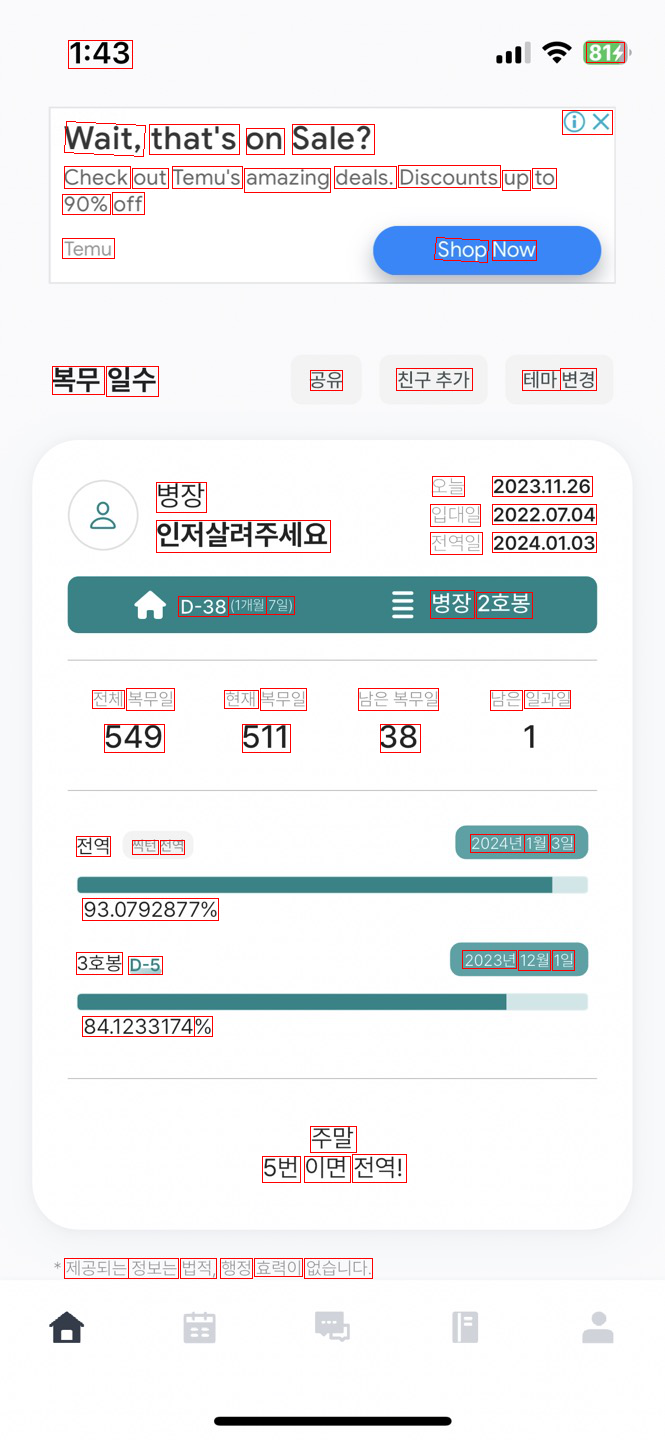

In [121]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 IAL


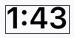

Result: 	 HESAHAS


Result: 	 ONASL


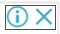

Result: 	 WAITI


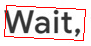

Result: 	 ITHATSL


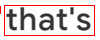

Result: 	 SALER


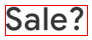

Result: 	 TARMLY


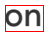

Result: 	 CHECK


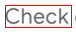

Result: 	 TEMUTSL


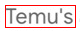

Result: 	 GEAIS


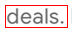

Result: 	 DISCOUNTSI


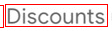

Result: 	 LIOTUTS


Result: 	 ILAMAZINGI


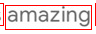

Result: 	 AICL


Result: 	 HTRSI


Result: 	 TAEL


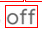

Result: 	 OTAL


Result: 	 EISMNTA


Result: 	 TSRSRS


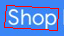

Result: 	 RARSES


Result: 	 EATAY


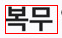

Result: 	 YEYOTS


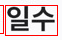

Result: 	 EATEZH


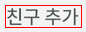

Result: 	 TEASL


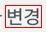

Result: 	 RIRS


Result: 	 ESIDIFS


Result: 	 ESTES


Result: 	 ZOZSILZAL


Result: 	 AES


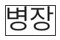

Result: 	 ESREITESH


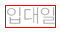

Result: 	 ZOPZOIOA


Result: 	 PLREAIFHIA


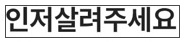

Result: 	 ESREREST


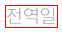

Result: 	 ZOPAOLOSI


Result: 	 TESRERN


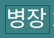

Result: 	 HIDESEST


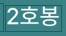

Result: 	 IPNST


Result: 	 SHASRARS


Result: 	 HERARIE


Result: 	 EAEST


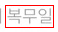

Result: 	 EARARSH


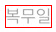

Result: 	 ERSAESY


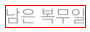

Result: 	 ESTESIN


Result: 	 SATHN


Result: 	 SRES


Result: 	 NSTATRES


Result: 	 SJ


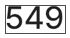

Result: 	 SI


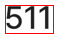

Result: 	 SY


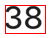

Result: 	 ORASR


Result: 	 HITRAIS


Result: 	 ARA


Result: 	 ISTEAL


Result: 	 STI


Result: 	 JESRESN


Result: 	 IBSOTOETTA


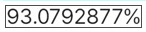

Result: 	 APONSRY


Result: 	 ERARASIT


Result: 	 ARASTS


Result: 	 SESES


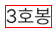

Result: 	 DRSL


Result: 	 EAIZESTZA


Result: 	 TISAL


Result: 	 PSCEDST


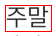

Result: 	 ISTALY


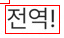

Result: 	 STEPY


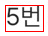

Result: 	 IOTESN


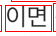

Result: 	 ESSTS


Result: 	 RSTERS


Result: 	 JIESESTAS


Result: 	 JLSTESL


Result: 	 NCAEAISH


Result: 	 VEASTES


In [122]:
for _img in cropped_img:
    recognize_img(_img)

## 모델 평가

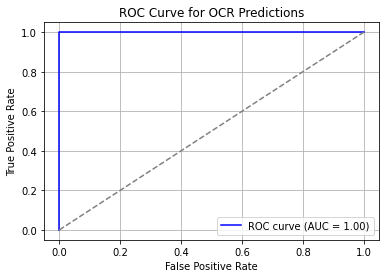

In [83]:
# Model Evaluations for Metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예시 데이터: 문자 별 확률과 정답 여부
y_true = [1, 1, 0, 1, 0]  # 1: 맞음, 0: 틀림
y_scores = [0.95, 0.87, 0.4, 0.91, 0.5]  # 모델이 출력한 확률 (confidence)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for OCR Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K # K.ctc_decode 등을 사용하기 위해
# import numpy as np # 이미 임포트 되어 있을 것입니다.
# import tensorflow as tf # 이미 임포트 되어 있을 것입니다.

In [87]:
# 이미 학습된 모델의 가중치를 로드한다고 가정합니다.
# checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5' # 저장된 가중치 경로

# 기존 build_crnn_model 함수를 사용하되, 추론을 위한 모델을 별도로 구성합니다.
# build_crnn_model 함수 내에서 image_input과 y_pred를 가져올 수 있도록 수정하거나,
# 모델 구조를 참조하여 추론 모델을 직접 만듭니다.

# 예시: 추론 모델 구성 (build_crnn_model 내부 구조 참조)
# image_input = model.get_layer('input_image').input # 학습 모델에서 입력 레이어 가져오기
# y_pred_output = model.get_layer('output').output   # 학습 모델에서 softmax 출력 레이어 가져오기
# inference_model = Model(inputs=image_input, outputs=y_pred_output)

# 또는, 모델을 새로 빌드하고 가중치를 로드합니다.
model_for_inference = build_crnn_model() # 동일한 구조로 모델 빌드
model_for_inference.load_weights(checkpoint_path) # 저장된 가중치 로드

# 최종적으로 추론에 사용할 모델은 image_input을 받아 y_pred를 출력해야 합니다.
# build_crnn_model의 정의에 따르면 'output' 레이어가 y_pred에 해당합니다.
# 따라서 전체 모델에서 추론 부분만 따로 떼어낼 필요 없이,
# 학습된 모델(model 변수)에서 input_image만 입력으로 하고 output 레이어의 출력을 얻도록 할 수 있습니다.
# 하지만 model.predict()를 사용할 때, 학습 시 정의된 모든 입력을 요구할 수 있으므로
# 명시적으로 추론용 모델을 만드는 것이 좋습니다.

image_input_tensor = model_for_inference.get_layer(name='input_image').input
y_pred_tensor = model_for_inference.get_layer(name='output').output
inference_model = Model(inputs=image_input_tensor, outputs=y_pred_tensor)

print("추론 모델이 준비되었습니다.")

추론 모델이 준비되었습니다.


In [89]:
# 평가용 데이터셋 준비 (val_set 또는 test_set 사용)
# 여기서는 val_set을 사용한다고 가정합니다.
# val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

all_y_true = []
all_y_scores = []

# val_set의 배치 크기 (또는 원하는 배치 크기)
eval_batch_size = BATCH_SIZE # 학습 시 사용한 BATCH_SIZE 또는 다른 값

for i in range(len(val_set)):
    batch_inputs, _ = val_set[i] # val_set.__getitem__(i) 호출
    images = batch_inputs['input_image']
    true_labels_encoded = batch_inputs['label'] # 인코딩된 실제 레이블
    
    # CRNN 모델의 y_pred는 (batch_size, time_steps, num_chars) 형태
    preds = inference_model.predict(images)
    
    # CTC 디코딩을 위한 input_length 설정
    # preds.shape[1]이 time_steps에 해당
    # build_crnn_model에서 sequence = layers.Reshape(target_shape=(24, 512))(feature)로 24 time steps
    pred_input_length = np.ones(preds.shape[0]) * preds.shape[1]

    # K.ctc_decode를 사용하여 디코딩 및 로그 확률 얻기
    decoded_sequences, log_probs = K.ctc_decode(preds, 
                                                input_length=pred_input_length,
                                                greedy=True)
    
    # 로그 확률을 실제 확률로 변환 및 스칼라 값으로 추출
    # 🔽 이 줄을 수정했습니다.
    current_scores = np.exp(K.eval(log_probs).flatten()) # log_probs 전체를 사용하여 모든 샘플의 점수를 계산합니다.

    for j in range(preds.shape[0]): # 배치 내 각 샘플에 대해
        # 실제 레이블 디코딩
        true_text_encoded = true_labels_encoded[j]
        true_text = label_converter.decode(true_text_encoded)
        true_text = true_text.replace('-', '').strip() # CTC blank 및 패딩 문자 제거

        # 예측된 레이블 디코딩
        predicted_text_encoded = K.eval(decoded_sequences[0][j])
        predicted_text = label_converter.decode(predicted_text_encoded)
        predicted_text = predicted_text.replace('-', '').strip() # CTC blank 및 패딩 문자 제거

        # "정확한" 인식 정의 (예: 완전 일치)
        is_correct = 1 if true_text == predicted_text else 0
        
        all_y_true.append(is_correct)
        all_y_scores.append(current_scores[j]) # 이제 current_scores[j]는 올바르게 접근됩니다.

print(f"총 {len(all_y_true)}개의 샘플에 대한 y_true 및 y_scores 생성 완료.")
# print(f"샘플 - y_true: {all_y_true[:10]}")
# print(f"샘플 - y_scores: {all_y_scores[:10]}")

총 8064개의 샘플에 대한 y_true 및 y_scores 생성 완료.


In [90]:
if len(all_y_true) > 0 and len(all_y_scores) > 0 and len(set(all_y_true)) > 1:
    fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 무작위 추측선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for CRNN Text Recognition')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC 커브를 그리기에 데이터가 충분하지 않거나 y_true에 하나의 클래스만 존재합니다.")
    if len(all_y_true) > 0 :
         print(f"y_true 샘플 (처음 10개): {all_y_true[:10]}")
         print(f"y_scores 샘플 (처음 10개): {all_y_scores[:10]}")
         print(f"y_true 고유값: {set(all_y_true)}")

ROC 커브를 그리기에 데이터가 충분하지 않거나 y_true에 하나의 클래스만 존재합니다.
y_true 샘플 (처음 10개): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_scores 샘플 (처음 10개): [64.39867, 13.46977, 55.921455, 4.0966296, 8.703097, 439050.06, 28.130878, 20.753216, 8.354775, 5.7111397]
y_true 고유값: {0}


In [95]:
all_y_true = []
all_y_scores = []
debug_limit = 20  # Print details for the first N samples for inspection
samples_printed = 0

eval_batch_size = BATCH_SIZE 

for i in range(len(val_set)):
    batch_inputs, _ = val_set[i]
    images = batch_inputs['input_image']
    true_labels_encoded = batch_inputs['label']

    preds = inference_model.predict(images)
    pred_input_length = np.ones(preds.shape[0]) * preds.shape[1]
    decoded_sequences, log_probs = K.ctc_decode(preds, 
                                                input_length=pred_input_length,
                                                greedy=True)
    current_scores = np.exp(K.eval(log_probs).flatten())

    for j in range(preds.shape[0]):
        true_text_encoded_sample = true_labels_encoded[j]
        true_text = label_converter.decode(true_text_encoded_sample)
        true_text_cleaned = true_text.replace('-', '').strip()

        predicted_text_encoded_sample = K.eval(decoded_sequences[0][j])
        predicted_text = label_converter.decode(predicted_text_encoded_sample)
        predicted_text_cleaned = predicted_text.replace('-', '').strip()

        is_correct = 1 if true_text_cleaned == predicted_text_cleaned else 0

        # ▼▼▼ 여기에 디버깅 프린트문 추가 ▼▼▼
        if samples_printed < debug_limit: # 예: 처음 20개 샘플만 자세히 출력
            print(f"--- Sample {i*eval_batch_size + j + 1} ---")
            print(f"True Decoded (Cleaned): '{true_text_cleaned}'")
            print(f"Predicted Decoded (Cleaned): '{predicted_text_cleaned}'")
            print(f"Score: {current_scores[j]:.4f}")
            print(f"Is Correct: {is_correct}")
            print("--------------------")
            samples_printed += 1
        # ▲▲▲ 여기까지 디버깅 프린트문 ▲▲▲

        all_y_true.append(is_correct)
        all_y_scores.append(current_scores[j])


print(f"총 {len(all_y_true)}개의 샘플에 대한 y_true 및 y_scores 생성 완료.")
if samples_printed >= debug_limit:
    print(f"Printed details for the first {debug_limit} samples. Check output above.")



--- Sample 1 ---
True Decoded (Cleaned): 'MONIKER'
Predicted Decoded (Cleaned): 'HLONIKER9999999999999999'
Score: 64.3987
Is Correct: 0
--------------------
--- Sample 2 ---
True Decoded (Cleaned): 'ECCLESIASTICS'
Predicted Decoded (Cleaned): 'ECLESIASTICS999999999999'
Score: 13.4698
Is Correct: 0
--------------------
--- Sample 3 ---
True Decoded (Cleaned): 'FIRESTORM'
Predicted Decoded (Cleaned): 'FRESTORIN999999999999999'
Score: 55.9215
Is Correct: 0
--------------------
--- Sample 4 ---
True Decoded (Cleaned): 'PSI'
Predicted Decoded (Cleaned): 'PSI999999999999999999999'
Score: 4.0966
Is Correct: 0
--------------------
--- Sample 5 ---
True Decoded (Cleaned): 'REPURCHASES'
Predicted Decoded (Cleaned): 'REPUICHESES9999999999999'
Score: 8.7031
Is Correct: 0
--------------------
--- Sample 6 ---
True Decoded (Cleaned): 'PIGTAIL'
Predicted Decoded (Cleaned): 'BUGH99999999999999999999'
Score: 439050.0625
Is Correct: 0
--------------------
--- Sample 7 ---
True Decoded (Cleaned): 'LANDLA

In [92]:
if len(all_y_true) > 0 and len(all_y_scores) > 0 and len(set(all_y_true)) > 1:
    fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 무작위 추측선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for CRNN Text Recognition')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("ROC 커브를 그리기에 데이터가 충분하지 않거나 y_true에 하나의 클래스만 존재합니다.")
    if len(all_y_true) > 0 :
         print(f"y_true 샘플 (처음 10개): {all_y_true[:10]}")
         print(f"y_scores 샘플 (처음 10개): {all_y_scores[:10]}")
         print(f"y_true 고유값: {set(all_y_true)}")

ROC 커브를 그리기에 데이터가 충분하지 않거나 y_true에 하나의 클래스만 존재합니다.
y_true 샘플 (처음 10개): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_scores 샘플 (처음 10개): [64.39867, 13.46977, 55.921455, 4.0966296, 8.703097, 439050.06, 28.130878, 20.753216, 8.354775, 5.7111397]
y_true 고유값: {0}


| 평가문항                                                                                        | 상세기준                                                     |
| ------------------------------------------------------------------------------------------- | -------------------------------------------------------- |
| 1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.                                           | 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다. |
| 2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.                                                | 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.             |
| 3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다. | 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.           |

# 회고

평가 지표를 생성하기 위해서 ROC Curve를 그려보려 했지만 ROC Curve 그리기에 실패 하였고, 이에 따라 스스로 질문을 던져보았다. 과연 이 과제가 ROC Curve를 그리기가 적합한 주제였나? 혹은 데이터가 ROC Curve를 그리기에 충분한가? 혹은 클래스가 하나만 존재 하는거 아닌가? 에 대한 답을 생각해보았을 때, 이에 대부분이 해당 됨을 인지하였고, 이 study는 ROC Curve그리기가 적합하지 않다는 결론을 내릴 수 있었다. 따라서 그러면 어떤 평가 지표를 사용 할까에 대한 고민을 하다, 음성 분석 지표로 사용 할 수 있는 Character Error Rate (CER) 과 Word Error Rate (WER) 이라는 인식된 문자열 과 정답 문자열 사이의 문자 요류 비율을 나타내는 지표와 인식된 단어열 과 정답 단어열 사이의 단어 오류 비율을 나타내는 지표가 있다는점을 알았다. 수식은 다음과 같이 정의되고, 
CER = 인식된 문자열 중 잘못된 문자의 개수 / 총 문자의 개수. 
WER = 인식된 단어열 중 잘못된 단어의 개수 / 총 단어의 개수. 
이를 기반으로 지표값이 낮을 수록 정확도가 좋다. 참고로 시간이 없어서 이를 적용해볼 수는 없어서 아쉬웠고, 다음부턴 시간 분배를 진짜 잘해서 안되는걸 계속 붙자고 어떡해든 해볼려고 고민 하지 말고 왜 안되는지 알겠으면 바로 다음으로 넘어가서 새로운 시도를 해봐야겠다. 
이번에 그런 부부분을 좀 뼈저리게 느낀것같다. 